In [4]:
!pip install woe

In [15]:
!pip install --upgrade woe

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from woe import WoE

ImportError: cannot import name 'WoE' from 'woe' (C:\Users\nejat\anaconda3\Lib\site-packages\woe\__init__.py)

In [8]:
def load_data(file_path):
    return pd.read_csv(file_path)

file_path = 'C:/Users/nejat/AIM Projects/week6 data/data.csv'
df = load_data(file_path)
print(df.head())  

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__']
         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          256  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          256  ProviderId_4   ProductId_6   
2  CustomerId_4683          UGX          256  ProviderId_6   ProductId_1   
3   CustomerId_988          UGX          256  ProviderId_1  ProductId_21   
4   CustomerId_988        

In [10]:
def calculate_rfms(df):
    df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'], errors='coerce')

    current_date = df['TransactionStartTime'].max()
    
    df['recency'] = (current_date - df['TransactionStartTime']).dt.days
    
    frequency = df.groupby('CustomerId')['TransactionId'].count().reset_index()
    frequency.columns = ['CustomerId', 'frequency']

    monetary = df.groupby('CustomerId')['Amount'].sum().reset_index()
    monetary.columns = ['CustomerId', 'monetary']

    rfms = frequency.merge(monetary, on='CustomerId', how='left')
    df = df.merge(rfms, on='CustomerId', how='left')

    df['recency_score'] = (df['recency'].max() - df['recency']) / df['recency'].max() * 100
    df['frequency_score'] = (df['frequency'] - df['frequency'].min()) / (df['frequency'].max() - df['frequency'].min()) * 100
    df['monetary_score'] = (df['monetary'] - df['monetary'].min()) / (df['monetary'].max() - df['monetary'].min()) * 100

    df['rfms_score'] = (df['recency_score'] * 0.15) + (df['frequency_score'] * 0.35) + (df['monetary_score'] * 0.50)
    
    return df

df = calculate_rfms(df)
print("RFMS Scores Calculated:")
print(df[['CustomerId', 'rfms_score']].head())

RFMS Scores Calculated:
        CustomerId  rfms_score
0  CustomerId_4406   28.885870
1  CustomerId_4406   28.885870
2  CustomerId_4683   27.855733
3   CustomerId_988   28.224254
4   CustomerId_988   28.224254


In [11]:
def classify_users(df, threshold=50):
    df['risk_label'] = np.where(df['rfms_score'] >= threshold, 'Good', 'Bad')
    return df

df = classify_users(df)
print("\nUsers Classified:")
print(df[['CustomerId', 'risk_label']].head())


Users Classified:
        CustomerId risk_label
0  CustomerId_4406        Bad
1  CustomerId_4406        Bad
2  CustomerId_4683        Bad
3   CustomerId_988        Bad
4   CustomerId_988        Bad


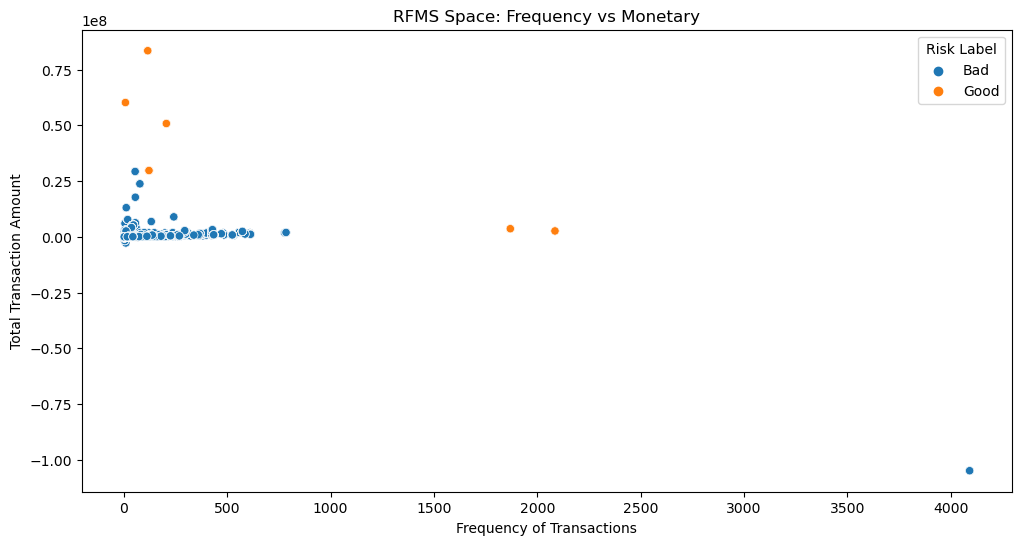

In [12]:
def visualize_rfms(df):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='frequency', y='monetary', hue='risk_label', data=df)
    plt.title("RFMS Space: Frequency vs Monetary")
    plt.xlabel("Frequency of Transactions")
    plt.ylabel("Total Transaction Amount")
    plt.legend(title='Risk Label')
    plt.show()

visualize_rfms(df)

In [19]:
def calculate_woe_iv(df, feature, target):
    total_good = df[target].sum()
    total_bad = len(df) - total_good

    woe_df = df.groupby(feature)[target].agg(['count', 'sum']).reset_index()
    woe_df.columns = [feature, 'total_count', 'good_count']

    woe_df['bad_count'] = woe_df['total_count'] - woe_df['good_count']
    woe_df['good_percentage'] = woe_df['good_count'] / total_good
    woe_df['bad_percentage'] = woe_df['bad_count'] / total_bad

    woe_df['woe'] = np.log(woe_df['good_percentage'] / woe_df['bad_percentage'].replace(0, np.nan))

    woe_df['iv'] = (woe_df['good_percentage'] - woe_df['bad_percentage']) * woe_df['woe']
    total_iv = woe_df['iv'].sum()

    return woe_df[[feature, 'good_count', 'bad_count', 'woe']], total_iv

woe_results, iv_value = calculate_woe_iv(df, 'Feature', 'Target')

print("WoE Results:")
print(woe_results)
print(f"Total Information Value (IV): {iv_value}")

WoE Results:
  Feature  good_count  bad_count       woe
0       A           2          1  0.287682
1       B           2          1  0.287682
2       C           2          2 -0.405465
Total Information Value (IV): 0.11552453009332421
